# Notes - Important !!!!
- GARCH, GARCH-t, EGARCH, EGARCH-t
    - droped own estimation since the main difference seemed to be initialization of filter and there's still a lot of coding
    - random state - not needed for stadardn estimation - if boostraped used for parameter then would need it
- pyflux - GAS
    - not working (cant donwload at the moment)
- hyperparameter selection on CV 
    - kfolds does not really make sense
    - instead rolling estimattion on trainset isperformed and one step ahead calculated
    - based on sum of lllik best specification is selected
  
- ToDos
    - reestiamte best models and append predictions to returns
    - append some window statistics as well 

    - look into tenserflow and other things to estimate based on LLik and have two outputs
        - mu 
        - sigma
    - evaluate best garch models and NN on test set
        - one step ahead?

- different stocks?
- LSTM NN?

### Setup

In [1]:
# load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from scipy.stats import norm, t
from arch import arch_model
from time import perf_counter

In [2]:
# classes and functions from 'util'
from util.data_load import returns_load
from util.ArchModelWrapper import ArchModelWrapper
from util.DescStat import DescStat
from util.Standardizer import Standardizer
from util.TrainTestSplitter import Splitter
# from util.ANN_core import NeuralNetwork

In [3]:
# setting seed for reproducibility
np.random.seed(1995)

In [4]:
# Variables used in code
start_dt = '2000-01-01'
end_dt = '2020-03-01'
ticker = 'MSFT' 
interval = '1d'

### Data Load

In [5]:
ret_data = returns_load(ticker=ticker,
                    interval=interval,
                    start_dt=start_dt,
                    end_dt=end_dt)
ret_data.set_index('dt', inplace=True)

[*********************100%***********************]  1 of 1 completed


### Data Split

In [6]:
Splitter_all = Splitter(train_part=0.7)
Splitter_garch = Splitter(train_part=0.1)
[train_data, test_data] = Splitter_all.split(dataset = ret_data['return100'])
[est_data_garch, eval_data_garch] = Splitter_garch.split(dataset = train_data)

Last observation in trainset: 2014-02-12 00:00:00 , 
            first observation in testset: 2014-02-13 00:00:00
Last observation in trainset: 2001-05-30 00:00:00 , 
            first observation in testset: 2001-05-31 00:00:00


### Garch estimation

In [7]:
models = ['GARCH', 'EGARCH']
p = list(range(1,5))
q = list(range(1,5))
dist = ['Normal', 'StudentsT']
index = pd.MultiIndex.from_product([models, p, q, dist], names = ['models', 'p', 'q', 'dist'])
space = pd.DataFrame(index = index).reset_index()

In [8]:
ArchMod = ArchModelWrapper(train_data=train_data, eval_data_garch=eval_data_garch)

In [ ]:
time_begin = perf_counter()
space['llik'] = space.apply(lambda row: ArchMod.estimate_predict(row['models'], row['p'], row['q'], row['dist']),
                                    axis=1)
f'Time of calculations: {round((perf_counter()-time_begin)/60, 0)} min'

In [11]:
predictions = ArchMod.get_predictions() 

### Select best specifications

In [98]:
best_spec = (
    space
        .groupby(['models', 'dist'])
        .agg({'llik':'max'})[['llik']]
        .reset_index()
        .merge(space, on=['models','dist','llik'])
)

In [13]:
best_spec_strings = best_spec.apply(lambda row : f'{row["models"]}-{row["dist"]}-{row["p"]}-{row["q"]}'
                , axis=1)

### Merge Predictions of best specifications

In [14]:
predictions_df = pd.DataFrame(index = eval_data_garch.index)
for mod in best_spec_strings : 
    predictions_df = predictions_df.merge(
        predictions[mod].add_suffix(f'_{mod}'),
        left_index=True,
        right_index = True, 
    )

In [15]:
predictions_df

,mean_pred_GARCH-Normal-1-1,var_pred_GARCH-Normal-1-1,mean_pred_GARCH-Normal-2-1,var_pred_GARCH-Normal-2-1
dt,,,,
2001-05-31,-0.091619,5.455279,0.014068,5.051279
2001-06-01,-0.093081,4.925953,0.014923,5.033681
2001-06-04,-0.084184,5.029869,0.021974,4.406089
2001-06-05,-0.080370,4.618953,0.024718,4.518127
2001-06-06,-0.065592,5.477332,0.036436,4.155100
...,...,...,...,...
2014-02-06,0.029465,3.177103,0.029468,3.177042
2014-02-07,0.029648,3.031691,0.029651,3.031635
2014-02-10,0.029862,2.905993,0.029870,2.905950


### Add Descriptive Features Calculated from returns

In [16]:
desc_obj = DescStat(data=eval_data_garch['return100'])

In [17]:
desc_data = (
    pd.DataFrame(
        {
            'mean5_return100': desc_obj.calc_mean(window=5, fill_initial='first_constant'),
            'var5_return100': desc_obj.calc_var(window=5, fill_initial='first_constant'),
            'dt': eval_data_garch.index
        }
    ).set_index('dt')
)

### Data for Neural Networks are prepared

In [18]:
enriched_ret_data = (
    eval_data_garch
        .merge(
            desc_data,
            left_index=True,
            right_index=True
        )
        .merge(
            predictions_df,
            left_index=True,
            right_index=True
        )
)

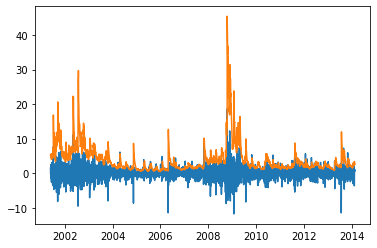

In [19]:
y1 = enriched_ret_data['return100']
y2 = enriched_ret_data['var_pred_GARCH-Normal-1-1']
y3 = enriched_ret_data['mean5_return100']
y4 = enriched_ret_data['var5_return100']
plt.plot(y1)
plt.plot(y2)
# plt.plot(y3)
# plt.plot(y4)
plt.show()

In [20]:
enriched_ret_data.shape

(3195, 7)

### Standardize the data

In [21]:
# initiate standardizer 
Standardizer_train = Standardizer(
    demean=True,
    rescale=True,
    skipna=True
)

In [22]:
# standardize all but first column where the returns are
train_data_standard = (
    enriched_ret_data
        .drop('return100', axis=1)
        .apply(
            func=Standardizer_train.perform_calc,
            axis=0,
            result_type='broadcast'
        )
        .join(enriched_ret_data[['return100']])
)

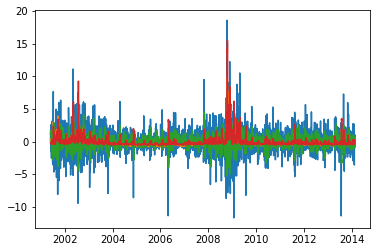

In [23]:
y1 = train_data_standard['return100']
y2 = train_data_standard['var_pred_GARCH-Normal-1-1']
y3 = train_data_standard['mean5_return100']
y4 = train_data_standard['var5_return100']
plt.plot(y1)
plt.plot(y2)
plt.plot(y3)
plt.plot(y4)
plt.show()

# Content of ANN_core - for easier manipulation here and then at the end of session copied to separate .py file

In [21]:
# =============================================================================
# define sigmoid function
# =============================================================================

def sigmoid(x):
    
    return 1/(1+ np.exp(-x))

# =============================================================================
# define sigmoid derivative function
# =============================================================================

def sigmoid_der(x):
    
#     return sigmoid(x) * (1 - sigmoid(x))
    return x * (1 - x)

# =============================================================================
# define log likelihood function
# =============================================================================

def lLik(obs_val, sigma_pred):

    LLik = -(1/2) * np.log(2 * np.pi) - (1/2) * np.log(sigma_pred ** 2) - (1/2) * ((obs_val** 2) / sigma_pred ** 2)

    return LLik	

# =============================================================================
# define derivation of log likelihood
# =============================================================================

def lLik_der(obs_val, sigma_pred):
    
    LLik_der = - 1 / sigma_pred + (1 / sigma_pred ** 3) * (obs_val ** 2)
    
    return LLik_der

# =============================================================================
# define squared errors
# =============================================================================

def square_error(obs_val, obs_pred):
    
    return (obs_val - obs_pred) ** 2

# =============================================================================
# define first derivative of squared errors
# =============================================================================
    
#in this case should be multiplied by -1 since with respect to obs_pred, but then 
#change in weights and biases is not += but -=
def square_error_der(obs_val, obs_pred):
    
    return  (obs_val - obs_pred)

# =============================================================================
# define linear function for case when only one layer
# =============================================================================
def linear(x):
    
    return x

# =============================================================================
# define derivative of linear 
# =============================================================================
def linear_der(x):
        
    return np.ones(x.shape)
# =============================================================================
# class object NeuralNetwork
# =============================================================================
    
class NeuralNetwork:

    def __init__(self, x, y, obj_fun = square_error, node_fun = linear,
                 hidden_layer = 1, step_rate = 0.001, bias = False, num_nodes = [1,0]):
        
        self.nodes1     = num_nodes[0]
        
        self.nodes2     = num_nodes[1]
        
        if obj_fun == square_error :
            
            self.obj_fun = square_error
            
            self.obj_fun_der = square_error_der
        
        elif obj_fun == lLik :
            
            self.obj_fun = lLik
            
            self.obj_fun_der = lLik_der
            
        else :
            
            print('set objective function to either squared errors or log-likelihood')
        
        self.input      = x
        
        self.y          = y

        self.output     = np.ones(self.y.shape)
        
        self.step_rate = step_rate
        
        self.bias = bias * 1
        
        if hidden_layer == 0 :
            
            self.weights_out = self.weights_hidden = np.ones([1,1])
            
            self.weights_input = np.random.rand(self.input.shape[1], 1)
            
            self.bias_out = self.bias_hidden = self.bias_input = np.zeros([1,1])
            
            self.node1_fun = linear
            
            self.node1_fun_der = linear_der
            
            self.node2_fun = linear
            
            self.node2_fun_der = linear_der
        
        elif hidden_layer == 1 :
            
            self.weights_out = np.ones([1,1])
            
            self.weights_hidden = np.random.rand(self.nodes1, 1)
            
            self.weights_input = np.random.rand(self.input.shape[1], self.nodes1)
            
            self.bias_out = self.bias_hidden = np.zeros([1,1])
            
            self.bias_input = np.zeros([1, self.nodes1])
            
            self.node1_fun = node_fun
            
            if node_fun == linear :
                
                self.node1_fun_der = linear_der
                
            elif node_fun == sigmoid :
                
                self.node1_fun_der = sigmoid_der
            
            self.node2_fun = linear
            
            self.node2_fun_der = linear_der
            
        elif hidden_layer == 2 :
            
            self.weights_out = np.random.rand(self.nodes2, 1)
            
            self.weights_hidden = np.random.rand(self.nodes1, self.nodes2)
            
            self.weights_input = np.random.rand(self.input.shape[1], self.nodes1)
            
            self.bias_out = np.zeros([1,1])
            
            self.bias_hidden = np.zeros([1, self.nodes2])
            
            self.bias_input = np.zeros([1, self.nodes1])
            
            self.node1_fun = self.node2_fun = node_fun
            
            if node_fun == linear :
                
                self.node1_fun_der = self.node2_fun_der = linear_der
                
            elif node_fun == sigmoid :
                
                self.node1_fun_der = self.node2_fun_der = sigmoid_der
                
            else:
                
                print('set the node function to either sigmoid or linear')
                
        else:
            
            print('set number of hidden layers to 0, 1 or 2')
            
    def feedforward(self):

        self.layer1 = self.node1_fun(np.dot(self.input, self.weights_input) + self.bias_input)
        
        self.layer2 = self.node2_fun(np.dot(self.layer1, self.weights_hidden) + self.bias_hidden)
        
        self.output = np.dot(self.layer2, self.weights_out) + self.bias_out
        
    def backprop(self):
        
        #calculate errors and partial derivatives
        
        error_out = self.obj_fun_der(self.y, self.output)
        
#         print(error_out.head())
        
        d_weights_out = np.dot(self.layer2.T, error_out) 
        
#         print(d_weights_out)
        
        error_hidden = np.dot(error_out, self.weights_out.T) * self.node2_fun_der(self.layer2) # this is derivative in terms of f(x) maybe should change to derivative in terms of x, then it needs to be layer1*weights_hidden
        
#         print(error_hidden[1:5])
        
        d_weights_hidden = np.dot(self.layer1.T, error_hidden) 
        
#         print(d_weights_hidden)
        
        error_input = np.dot(error_hidden, self.weights_hidden.T) * self.node1_fun_der(self.layer1)
        
#         print(error_input[1:5])
        
        d_weights_input = np.dot(self.input.T, error_input)
        
#         print(d_weights_input)
        
        d_bias_out = np.dot(np.ones(self.output.shape[0]), error_out) 
        
        d_bias_hidden = np.dot(np.ones(self.layer2.shape[0]), error_hidden)
        
        d_bias_input = np.dot(np.ones(self.input.shape[0]), error_input)
        
        #update weights and biases
        
        self.weights_out += d_weights_out * self.step_rate * (self.nodes2 > 0)
        
        self.weights_hidden += d_weights_hidden * self.step_rate * (self.nodes1 > 0) 
        
        self.weights_input += d_weights_input * self.step_rate
        
        self.bias_out += d_bias_out * self.step_rate * self.bias * (self.nodes2 > 0)
        
        self.bias_hidden += d_bias_hidden * self.step_rate * self.bias * (self.nodes1 > 0)
        
        self.bias_input += d_bias_input * self.step_rate * self.bias
    
    def cost(self, new_input = None, new_y = None):
        # check if different input specified
        if new_input is None and new_y is None: 
            # if not - get the cost from training
            return np.sum(self.obj_fun(self.y, self.output))
        else:
            # if yes - get new prediction 
            layer1 = self.node1_fun(np.dot(new_input, self.weights_input) + self.bias_input)
            layer2 = self.node2_fun(np.dot(layer1, self.weights_hidden) + self.bias_hidden)
            predicted_output = np.dot(layer2, self.weights_out) + self.bias_out

            return np.sum(self.obj_fun(new_y, predicted_output))
    
    def predict(self, new_input = None):
        # check if different input specified
        if new_input is None: 
            # if not - get the output from training
            return self.output
        else:
            # if yes - get new prediction 
            layer1 = self.node1_fun(np.dot(new_input, self.weights_input) + self.bias_input)
            layer2 = self.node2_fun(np.dot(layer1, self.weights_hidden) + self.bias_hidden)
            predicted_output = np.dot(layer2, self.weights_out) + self.bias_out

            return predicted_output
        
    
    # this has been here for debugging
    def get_observed(self):
        return self.y
    def get_layer1(self):
        return self.layer1
    def get_layer2(self):
        return self.layer2
    def get_weights(self):
        return [self.weights_input, self.weights_hidden, self.weights_out]
    def get_input(self): 
        return self.input


### NN Estimation

In [22]:
NN_obj = NeuralNetwork(
    x=train_data_standard.drop('return100', axis=1),
    y=train_data_standard[['return100']],
    obj_fun=lLik,
    hidden_layer=1,
    node_fun=sigmoid,
    num_nodes=[4,0],
    step_rate=0.0001
)

In [23]:
NN_obj.feedforward()
for i in range(5000) :
        NN_obj.backprop()
        NN_obj.feedforward()
        print(i)
        print(NN_obj.cost()[0])

-7085.087958314149
-7035.854399313832
-6989.879598947458
-6947.473693253889
-6908.8756753657435
-6874.231508363253
-6843.577379380693
-6816.831702105405
-6793.798527500829
-6774.183064363883
-6757.617469150289
-6743.69274616925
-6731.9913602109145
-6722.115464140714
-6713.707290428259
-6706.460521232437
-6700.123488925565
-6694.496308412068
-6689.424394393716
-6684.790503341188
-6680.506812897091
-6676.507902074832
-6672.744984197035
-6669.181414874909
-6665.789325124849
-6662.5471665835175
-6659.437955637949
-6656.448032505348
-6653.566189349237
-6650.783057828176
-6648.090676755584
-6645.482183940254
-6642.951593477259
-6640.493631989884
-6638.103615819511
-6635.777356967139
-6633.511089515516
-6631.301410896611
-6629.145234133566
-6627.039748367448
-6624.982385772499
-6622.970793499595
-6621.002809653122
-6619.076442558664
-6617.189852755349
-6615.341337272464
-6613.529315840959
-6611.752318758029
-6610.008976173847
-6608.29800860874
-6606.618218539994
-6604.96848292201
-6603.347746

-6398.898698784773
-6398.605852308347
-6398.313356996243
-6398.021211870582
-6397.729415974642
-6397.437968372804
-6397.146868150486
-6396.856114414077
-6396.56570629085
-6396.275642928893
-6395.985923497005
-6395.696547184617
-6395.407513201679
-6395.118820778558
-6394.8304691659305
-6394.5424576346595
-6394.25478547567
-6393.967451999831
-6393.680456537803
-6393.393798439921
-6393.107477076027
-6392.82149183534
-6392.535842126288
-6392.250527376356
-6391.965547031916
-6391.680900558064
-6391.396587438441
-6391.11260717506
-6390.828959288119
-6390.54564331582
-6390.262658814177
-6389.9800053568215
-6389.6976825348065
-6389.415689956408
-6389.134027246915
-6388.852694048429
-6388.571690019651
-6388.291014835671
-6388.010668187749
-6387.730649783101
-6387.450959344681
-6387.171596610955
-6386.892561335677
-6386.61385328767
-6386.335472250592
-6386.057418022716
-6385.779690416691
-6385.502289259319
-6385.225214391323
-6384.948465667114
-6384.6720429545585
-6384.395946134751
-6384.1201751

-6302.844029720358
-6302.719242886985
-6302.594837100493
-6302.47081191454
-6302.34716687973
-6302.22390154364
-6302.101015450828
-6301.978508142847
-6301.856379158275
-6301.734628032714
-6301.613254298817
-6301.492257486301
-6301.371637121963
-6301.251392729695
-6301.131523830501
-6301.0120299425125
-6300.892910581009
-6300.774165258424
-6300.6557934843695
-6300.537794765647
-6300.42016860627
-6300.302914507469
-6300.186031967717
-6300.069520482741
-6299.953379545536
-6299.837608646389
-6299.722207272878
-6299.607174909912
-6299.49251103972
-6299.378215141886
-6299.264286693359
-6299.150725168463
-6299.0375300389205
-6298.924700773861
-6298.812236839844
-6298.700137700866
-6298.588402818385
-6298.477031651325
-6298.366023656102
-6298.255378286632
-6298.145094994349
-6298.035173228222
-6297.925612434767
-6297.816412058063
-6297.707571539769
-6297.599090319134
-6297.490967833023
-6297.383203515918
-6297.275796799942
-6297.168747114874
-6297.062053888161
-6296.955716544935
-6296.84973450

-6275.654038923322
-6275.633995921984
-6275.614043641219
-6275.594181609744
-6275.574409358052
-6275.554726418404
-6275.5351323248315
-6275.515626613132
-6275.496208820869
-6275.476878487374
-6275.457635153745
-6275.438478362844
-6275.41940765929
-6275.400422589471
-6275.381522701531
-6275.362707545373
-6275.343976672658
-6275.325329636803
-6275.306765992978
-6275.288285298109
-6275.26988711087
-6275.251570991685
-6275.233336502729
-6275.21518320792
-6275.19711067292
-6275.1791184651365
-6275.161206153716
-6275.143373309542
-6275.1256195052365
-6275.107944315157
-6275.09034731539
-6275.0728280837575
-6275.055386199804
-6275.038021244805
-6275.020732801759
-6275.003520455381
-6274.986383792112
-6274.969322400106
-6274.952335869231
-6274.935423791069
-6274.918585758909
-6274.90182136775
-6274.885130214292
-6274.868511896937
-6274.851966015787
-6274.835492172641
-6274.819089970991
-6274.802759016016
-6274.786498914589
-6274.770309275264
-6274.754189708276
-6274.738139825543
-6274.72215924

-6271.197455479334
-6271.191747246194
-6271.186043810969
-6271.180345136498
-6271.1746511858655
-6271.168961922407
-6271.163277309695
-6271.15759731155
-6271.151921892026
-6271.14625101542
-6271.140584646269
-6271.134922749341
-6271.129265289642
-6271.123612232405
-6271.117963543102
-6271.1123191874285
-6271.10667913131
-6271.101043340901
-6271.095411782577
-6271.089784422942
-6271.084161228818
-6271.07854216725
-6271.072927205501
-6271.067316311054
-6271.061709451606
-6271.0561065950715
-6271.050507709576
-6271.044912763458
-6271.0393217252695
-6271.033734563767
-6271.02815124792
-6271.0225717469
-6271.0169960300855
-6271.011424067063
-6271.005855827614
-6271.000291281727
-6270.9947303995905
-6270.989173151585
-6270.983619508295
-6270.978069440498
-6270.972522919169
-6270.966979915471
-6270.9614404007625
-6270.955904346593
-6270.950371724701
-6270.944842507012
-6270.939316665639
-6270.933794172881
-6270.928275001222
-6270.922759123327
-6270.917246512046
-6270.911737140408
-6270.906230

-6268.868900564349
-6268.863626255172
-6268.8583513205285
-6268.853075757702
-6268.847799563986
-6268.8425227366915
-6268.837245273137
-6268.83196717066
-6268.826688426608
-6268.821409038341
-6268.816129003234
-6268.810848318672
-6268.805566982056
-6268.800284990797
-6268.795002342321
-6268.789719034065
-6268.784435063478
-6268.779150428023
-6268.7738651251775
-6268.768579152425
-6268.7632925072685
-6268.758005187217
-6268.752717189798
-6268.747428512546
-6268.742139153008
-6268.736849108747
-6268.731558377336
-6268.726266956357
-6268.720974843409
-6268.715682036099
-6268.710388532047
-6268.705094328885
-6268.699799424257
-6268.69450381582
-6268.6892075012365
-6268.68391047819
-6268.6786127443675
-6268.673314297471
-6268.668015135212
-6268.662715255318
-6268.657414655523
-6268.652113333574
-6268.646811287228
-6268.641508514256
-6268.636205012439
-6268.630900779567
-6268.625595813443
-6268.620290111882
-6268.614983672708
-6268.609676493757
-6268.6043685728755
-6268.599059907922
-6268.59

-6266.425707219045
-6266.420030635952
-6266.414353177941
-6266.408674846485
-6266.402995643068
-6266.397315569178
-6266.391634626318
-6266.385952815998
-6266.380270139738
-6266.374586599066
-6266.3689021955215
-6266.363216930652
-6266.357530806015
-6266.351843823178
-6266.346155983715
-6266.340467289213
-6266.334777741267
-6266.329087341482
-6266.3233960914695
-6266.317703992854
-6266.312011047268
-6266.306317256354
-6266.300622621761
-6266.2949271451525
-6266.289230828197
-6266.283533672573
-6266.277835679973
-6266.27213685209
-6266.266437190634
-6266.2607366973225
-6266.255035373881
-6266.249333222045
-6266.24363024356
-6266.237926440179
-6266.232221813667
-6266.226516365796
-6266.22081009835
-6266.215103013117
-6266.209395111902
-6266.203686396515
-6266.1979768687725
-6266.192266530506
-6266.186555383552
-6266.18084342976
-6266.175130670986
-6266.169417109095
-6266.163702745965
-6266.157987583478
-6266.152271623529
-6266.146554868023
-6266.14083731887
-6266.1351189779925
-6266.12939

-6263.807961196082
-6263.802164138471
-6263.796367620115
-6263.790571644898
-6263.784776216698
-6263.7789813393965
-6263.773187016867
-6263.767393252986
-6263.761600051624
-6263.755807416648
-6263.750015351929
-6263.744223861328
-6263.738432948709
-6263.73264261793
-6263.726852872847
-6263.721063717317
-6263.715275155189
-6263.709487190315
-6263.703699826538
-6263.697913067702
-6263.692126917647
-6263.686341380213
-6263.680556459233
-6263.67477215854
-6263.6689884819625
-6263.663205433328
-6263.657423016456
-6263.651641235169
-6263.645860093283
-6263.640079594612
-6263.634299742966
-6263.628520542154
-6263.622741995976
-6263.616964108237
-6263.611186882731
-6263.605410323254
-6263.599634433595
-6263.593859217543
-6263.58808467888
-6263.582310821386
-6263.576537648839
-6263.57076516501
-6263.5649933736695
-6263.559222278582
-6263.55345188351
-6263.547682192212
-6263.541913208442
-6263.536144935949
-6263.530377378482
-6263.52461053978
-6263.518844423586
-6263.5130790336325
-6263.50731437

-6261.382646353084
-6261.377374782836
-6261.372104849892
-6261.366836555
-6261.3615698989
-6261.356304882325
-6261.351041506003
-6261.345779770649
-6261.340519676973
-6261.3352612256795
-6261.330004417459
-6261.3247492530045
-6261.319495732992
-6261.314243858093
-6261.308993628973
-6261.30374504629
-6261.298498110692
-6261.293252822821
-6261.288009183312
-6261.282767192791
-6261.277526851878
-6261.272288161186
-6261.26705112132
-6261.261815732875
-6261.256581996442
-6261.251349912604
-6261.246119481937
-6261.240890705007
-6261.235663582376
-6261.230438114597
-6261.225214302215
-6261.219992145771
-6261.214771645795
-6261.209552802811
-6261.204335617338
-6261.199120089885
-6261.193906220954
-6261.188694011042
-6261.183483460637
-6261.17827457022
-6261.173067340267
-6261.167861771244
-6261.162657863613
-6261.157455617825
-6261.152255034328
-6261.14705611356
-6261.1418588559545
-6261.1366632619365
-6261.131469331925
-6261.12627706633
-6261.121086465557
-6261.115897530004
-6261.110710260063

-6259.22712471307
-6259.222565734311
-6259.21800825468
-6259.213452273402
-6259.208897789693
-6259.204344802774
-6259.199793311864
-6259.195243316184
-6259.190694814955
-6259.186147807395
-6259.181602292727
-6259.177058270169
-6259.172515738943
-6259.167974698271
-6259.163435147372
-6259.15889708547
-6259.154360511783
-6259.149825425537
-6259.145291825949
-6259.140759712245
-6259.136229083646
-6259.131699939374
-6259.127172278653
-6259.122646100706
-6259.118121404756
-6259.113598190024
-6259.109076455739
-6259.104556201123
-6259.1000374254
-6259.095520127796
-6259.091004307533
-6259.08648996384
-6259.0819770959415
-6259.077465703063
-6259.072955784432
-6259.068447339277
-6259.063940366821
-6259.059434866295
-6259.054930836925
-6259.050428277942
-6259.045927188572
-6259.041427568045
-6259.036929415593
-6259.0324327304415
-6259.027937511824
-6259.023443758972
-6259.018951471115
-6259.014460647484
-6259.009971287314
-6259.0054833898375
-6259.000996954285
-6258.996511979893
-6258.992028465

-6257.344047472577
-6257.340086505761
-6257.336126771416
-6257.3321682691585
-6257.328210998605
-6257.324254959375
-6257.320300151088
-6257.316346573363
-6257.312394225821
-6257.308443108084
-6257.3044932197745
-6257.300544560514
-6257.296597129929
-6257.29265092764
-6257.288705953277
-6257.284762206462
-6257.280819686824
-6257.27687839399
-6257.272938327589
-6257.268999487248
-6257.265061872598
-6257.26112548327
-6257.257190318894
-6257.253256379103
-6257.249323663527
-6257.245392171804
-6257.241461903563
-6257.237532858443
-6257.2336050360755
-6257.2296784361
-6257.225753058152
-6257.221828901867
-6257.217905966887
-6257.2139842528495
-6257.210063759392
-6257.206144486157
-6257.202226432786
-6257.19830959892
-6257.1943939841985
-6257.190479588269
-6257.186566410773
-6257.182654451353
-6257.178743709657
-6257.174834185331
-6257.170925878018
-6257.167018787368
-6257.163112913027
-6257.159208254643
-6257.155304811866
-6257.151402584346
-6257.1475015717315
-6257.143601773674
-6257.139703

-6255.722550393117
-6255.719098941565
-6255.715648589216
-6255.71219933577
-6255.708751180924
-6255.705304124378
-6255.70185816583
-6255.69841330498
-6255.694969541522
-6255.691526875158
-6255.688085305583
-6255.684644832496
-6255.681205455591
-6255.677767174569
-6255.674329989123
-6255.670893898952
-6255.667458903752
-6255.664025003217
-6255.660592197044
-6255.657160484929
-6255.653729866566
-6255.650300341652
-6255.646871909879
-6255.643444570943
-6255.640018324539
-6255.63659317036
-6255.633169108101
-6255.629746137454
-6255.6263242581135
-6255.622903469772
-6255.619483772123
-6255.616065164858
-6255.612647647672
-6255.6092312202545
-6255.605815882298
-6255.602401633495
-6255.598988473535
-6255.595576402113
-6255.592165418917
-6255.588755523638
-6255.585346715967
-6255.581938995594
-6255.578532362208
-6255.575126815501
-6255.57172235516
-6255.568318980877
-6255.564916692339
-6255.561515489235
-6255.558115371254
-6255.5547163380825
-6255.551318389411
-6255.547921524925
-6255.54452574

### Results on Training Dataset

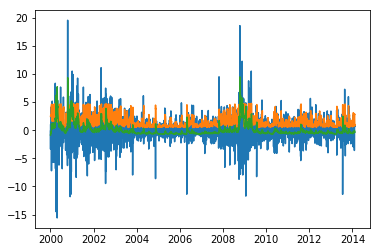

In [24]:
# Plot results
y1 = train_data_standard['return100']
y2 = pd.DataFrame(data=NN_obj.predict(), index = train_data_standard.index)
y3 = train_data_standard['garch']
plt.plot(y1)
plt.plot(y2)
plt.plot(y3)
plt.show()

In [25]:
# Compare Log-Likelihoods
print(
    f'''
    Calculations on training dataset
    Log_likelihood of average sigma : {lLik(obs_val=train_data[['return100']].to_numpy(), sigma_pred=np.sqrt(train_data[['var5_return100']].to_numpy())).sum()}
    Log_likelihood of Garch prediction : {lLik(obs_val=train_data[['return100']].to_numpy(), sigma_pred=np.sqrt(train_data[['garch']].to_numpy())).sum()} 
    Log_likelihood of NN prediction : {lLik(obs_val=train_data[['return100']].to_numpy(), sigma_pred=NN_obj.predict()).sum()}
    '''
)


    Calculations on training dataset
    Log_likelihood of average sigma : -6338.880172227772
    Log_likelihood of Garch prediction : -7110.505715097287 
    Log_likelihood of NN prediction : -6255.32943574723
    


### Results on Testing Dataset

In [26]:
# standardize all but first column where the returns are
test_data_standard = (
    test_data
        .drop('return100', axis=1)
        .apply(
            func=Standardizer_train.predict,
            axis=0,
            result_type='broadcast'
        )
        .join(test_data[['return100']])
)

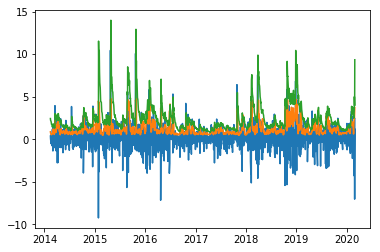

In [36]:
# Plot results
y1 = test_data_standard['return100']
y2 = pd.DataFrame(
        data=NN_obj.predict(new_input=test_data_standard.drop('return100', axis=1)), 
        index = test_data_standard.index
)
y3 = test_data['garch']
plt.plot(y1)
plt.plot(y2)
plt.plot(y3)
plt.show()

In [28]:
# Compare Log-Likelihoods
print(
    f'''
    Calculations on testing dataset
    Log_likelihood of average sigma : {lLik(obs_val=test_data[['return100']].to_numpy(), sigma_pred=np.sqrt(test_data[['var5_return100']].to_numpy())).sum()}
    Log_likelihood of Garch prediction : {lLik(obs_val=test_data[['return100']].to_numpy(), sigma_pred=np.sqrt(test_data[['garch']].to_numpy())).sum()} 
    Log_likelihood of NN prediction : {lLik(obs_val=test_data[['return100']].to_numpy(), sigma_pred=NN_obj.predict(new_input=test_data_standard.drop('return100', axis=1))).sum()}
    '''
)


    Calculations on testing dataset
    Log_likelihood of average sigma : -2308.323036289985
    Log_likelihood of Garch prediction : -2655.5895981410513 
    Log_likelihood of NN prediction : -2256.7041084499865
    


# Old Stuff

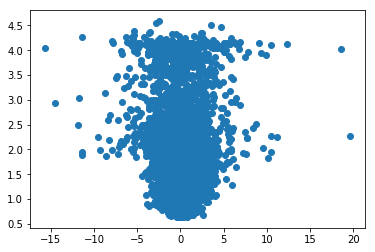

In [88]:
x = ret_data_enriched['return100']
y1 = NN_obj.get_output()
plt.scatter(x, y1)
# plt.plot(x, y2)
# plt.plot(x, y3)
# plt.plot(x, y4)
plt.show()

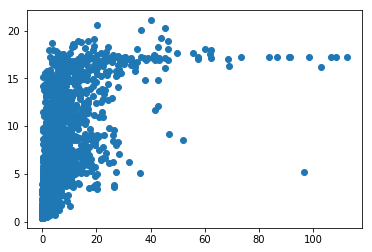

In [87]:
x = ret_data_enriched['var5_return100']
y1 = NN_obj.get_output()**2
plt.scatter(x, y1)
# plt.plot(x, y2)
# plt.plot(x, y3)
# plt.plot(x, y4)
plt.show()

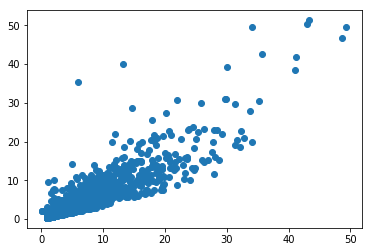

In [152]:
x = ret_data_enriched['garch']
y1 = NN_obj.get_output()
plt.scatter(x, y1)
# plt.plot(x, y2)
# plt.plot(x, y3)
# plt.plot(x, y4)
plt.show()

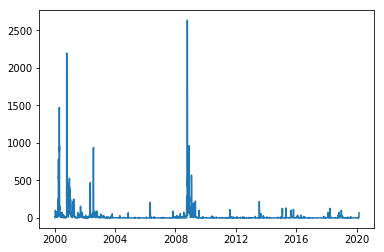

In [153]:
x = ret_data_enriched['dt']
y1 = ret_data_enriched['return100']
y2 = NN_obj.get_output() ** 2

plt.plot(x, y2)
plt.show()

In [41]:
NN_obj.get_weights()

[array([[ 1611837.73953872,   792260.24165044,  3004553.48070382,
          2317186.63723816,    26113.79160933],
        [ -636672.50907852,  -312940.81757742, -1186793.19034473,
          -915284.50135104,   -10314.20258629],
        [  218095.67899916,   107199.74056005,   406542.79422921,
           313535.79090393,     3534.01724127]]), array([[-386882.25280562],
        [ 250766.54755467],
        [ 354540.75900508],
        [-298564.0318481 ],
        [2000590.27145576]]), array([[1.]])]